In [52]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Word cloud generation
from wordcloud import WordCloud

# Text Processing
from utils import process_text

# Topic Modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Visual parameters
sns.set_style("whitegrid")
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["axes.edgecolor"] = "k"

In [53]:
ticker = "DIS"
true_labels = pd.read_csv("data/true_labels_gpt.csv", index_col=0, parse_dates=True)

true_labels.head()

,DIS,processed_text,sentiment
2022-10-06 16:25:00,JAKKS Pacific: Toy Company On The Mend; Watch ...,jakks pacific toy company mend watch upcoming,Neutral
2022-10-06 17:06:00,Disney: Sanderson Sisters Lead The Fourth Quarter,disney sanderson sisters lead fourth quarter,Neutral
2022-10-06 23:25:00,JAKKS Pacific: Relative Undervaluation Makes I...,jakks pacific relative undervaluation makes buy,Positive
2022-10-06 23:41:09,ESPN Nears Large New Partnership With DraftKings,espn nears large new partnership draftkings,Neutral
2022-10-06 23:57:00,DraftKings Shares Gain 8% After Report of Poss...,draftkings shares gain report possible espn pa...,Positive


In [54]:
# Function to remove redundant words from a row of text
def remove_redundant_words(row, redundancies):
    row["processed_text_list"] = [w for w in row["processed_text_list"] if w not in redundancies]
    return row

# Function to concatenate lists of words into entire strings
def get_entire_strings(*texts):
    entire_strings = []
    for text in texts:
        entire_strings.append(" ".join(text.explode()))
    return tuple(entire_strings)

# Function to generate WordClouds from strings
def generate_wcs(*strings):
    wcs = []
    for string in strings:
        wc = WordCloud(
            background_color="white", 
            height=400, 
            width=800, 
            colormap="Dark2"
        )
        wcs.append(wc.generate(string))
    return tuple(wcs)

# Function to plot a WordCloud
def plot_wc(wc, figsize=(10, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Make processed text column a list
true_labels["processed_text_list"] = true_labels["processed_text"].apply(lambda x: str(x).split())

# Separating data into positive, neutral, and negative sentiments
positive = true_labels["sentiment"] == "Positive"
neutral = true_labels["sentiment"] == "Neutral"
negative = true_labels["sentiment"] == "Negative"

# List of redundant words to remove
redundant_words = ["disney"]

# Applying the remove_redundant_words function to each sentiment group
true_labels_pos = true_labels[positive].apply(
    remove_redundant_words, redundancies=redundant_words, axis=1
)
true_labels_neg = true_labels[negative].apply(
    remove_redundant_words, redundancies=redundant_words, axis=1
)
true_labels_neu = true_labels[neutral].apply(
    remove_redundant_words, redundancies=redundant_words, axis=1
)

# Concatenating processed text into entire strings for each sentiment
pos_words, neu_words, neg_words = get_entire_strings(
    true_labels_pos["processed_text_list"], 
    true_labels_neu["processed_text_list"], 
    true_labels_neg["processed_text_list"]
)

# Generating WordClouds for each sentiment
pos_wc, neg_wc, neu_wc = generate_wcs(pos_words, neg_words, neu_words)

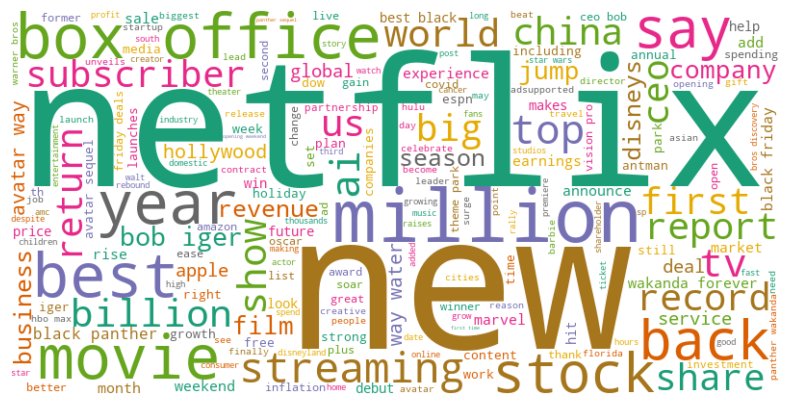

In [55]:
plot_wc(pos_wc)

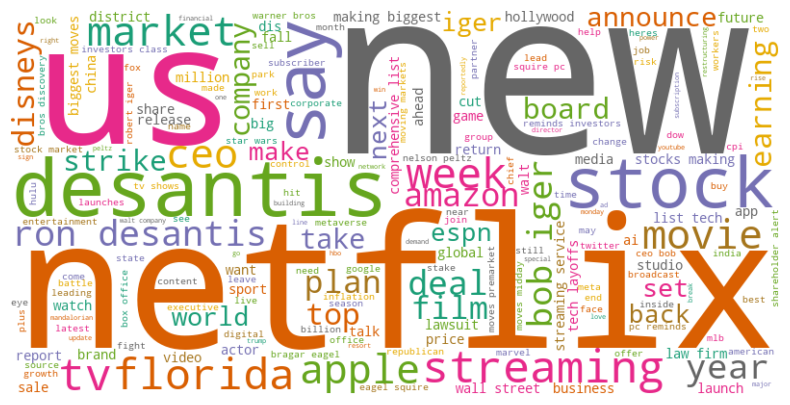

In [56]:
plot_wc(neu_wc)

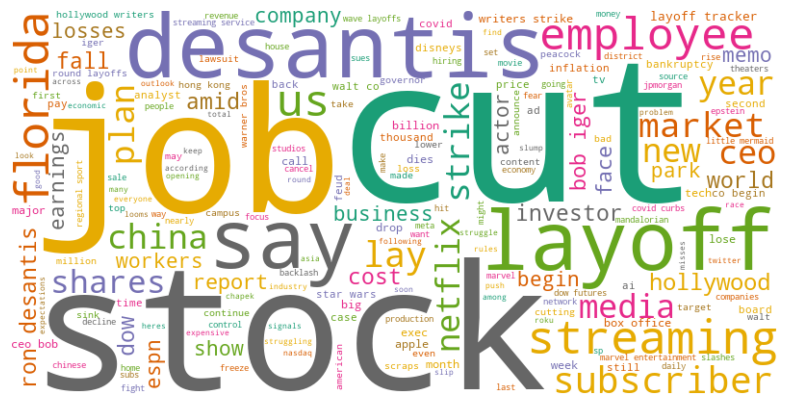

In [57]:
plot_wc(neg_wc)

In [73]:
# Function to display topics post modeling
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx+1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words-1:-1]]))
        print("="*100)

# Categorize text corpora based on sentiment categories
corpora = {
    "positive": true_labels_pos["processed_text"].values,
    "neutral": true_labels_neu["processed_text"].values,
    "negative": true_labels_neg["processed_text"].values
}

# Initialize Vectorizer; stop words have already been removed
vectorizer = TfidfVectorizer()

# Intialize LDA
n_topics = 5
n_top_words = 15
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)

# Transform corpora into TFIDF matrices
matrices = {k: v for k, v in corpora.items()}

for sentiment in matrices.keys():
    print(sentiment.upper())
    matrices[sentiment] = vectorizer.fit_transform(matrices[sentiment])
    lda.fit(matrices[sentiment])
    display_topics(lda, vectorizer.get_feature_names_out(), n_top_words)
    print()

POSITIVE
Topic #1:
disney ceo new back iger bob million netflix office box china weekend covid antman extends
Topic #2:
deals best friday black new disney netflix espn year partnership shares says streaming draftkings stock
Topic #3:
hbo disney max streaming best dow super animation big thousands time movies services bowl stock
Topic #4:
avatar disney box office million water way best black netflix billion panther disneyland sequel tv
Topic #5:
pro vision disney netflix apple new earnings launch nasdaq st strong beat business futures plans

NEUTRAL
Topic #1:
disney list layoffs tech comprehensive market shareholder stock things florida law firm alert opens fight
Topic #2:
making biggest eagel bragar squire pc moves class reminds investors disney premarket stocks season netflix
Topic #3:
disney desantis ron new dis announces coming markets netflix florida earnings streaming whats us stocks
Topic #4:
disney hollywood strike iger writers us stocks bob movies tv actors streaming desantis a

In [43]:
# Function to print the top words for each topic
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx+1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words-1:-1]]))
        print("="*100)

# Display the top 10 words for each topic
num_top_words = 15
display_topics(lda_model, vectorizer.get_feature_names_out(), num_top_words)

Topic #1:
iger stocks ceo bob hollywood strike earnings investors streaming market stock biggest dow new writers
Topic #2:
desantis florida ron board layoffs tech new market says list peltz dis announces back lawsuit
Topic #3:
netflix streaming new million avatar best office box sports movies us tv subscribers black warner
